# Poker hand classification
This notebook looks to build a machine learning model that can accuractely classify a poker hand given a 5 cards. Basically a model for poker hand rule induction.

Although this is absolutely something that is better built for a stgandard logic based classification system, e.g. if two of the same number then its a pair, I am curious to see how the model does. 

The data comes from the Kaggle `Poker Hand Classification` dataset, found at https://www.kaggle.com/dysphoria/poker-hand-classification?select=poker-hand-training.data

<br/>

#### Features
10 Attributes describing cards. \
1 label describing poker hand value (this is what we want to predict). \

The 5 cards of the hand are set out in the following attribute format:
* Suit of card #n, where 1-4 indicates {Hearts, Spades, Diamond, Clubs}
* Number of card #n, where 1-13 indicates {Ace, 2, 3, ..., Queen, King}

<br/>
 
The poker hand value refers to the following list: 
* 0: nothing in hand; not a recognized poker hand
* 1: one pair; one pair of equal ranks within five cards
* 2: two pairs; two pairs of equal ranks within five cards
* 3: three of a kind; three equal ranks within five cards
* 4: straight; five cards, sequentially ranked with no gaps
* 5: flush; five cards with the same suit
* 6: full house; pair + different rank three of a kind
* 7: four of a kind; four equal ranks within five cards
* 8: straight flush; straight + flush
* 9: royal flush; {Ace, King, Queen, Jack, Ten} + flush 


In [1]:
# Import all the tools we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Models from SCikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [3]:
# load data
df = pd.read_csv('./data/poker-hand-training.csv')
# where S1 = the suit of card1, and C1 = the card value of card1
df.columns = ["S1", "C1", "S2", "C2", "S3", "C3", "S4", "C4", "S5", "C5", "Hand"]
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
0,2,11,2,13,2,10,2,12,2,1,9
1,3,12,3,11,3,13,3,10,3,1,9
2,4,10,4,11,4,1,4,13,4,12,9
3,4,1,4,13,4,12,4,11,4,10,9
4,1,2,1,4,1,5,1,3,1,6,8


## Data Exploration

In [13]:
# investigate basic data structure
print(df.shape)
print(df.info());
# Check if there are missing values
df.isna().sum()  # There are no missing values

(25009, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25009 entries, 0 to 25008
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   S1      25009 non-null  int64
 1   C1      25009 non-null  int64
 2   S2      25009 non-null  int64
 3   C2      25009 non-null  int64
 4   S3      25009 non-null  int64
 5   C3      25009 non-null  int64
 6   S4      25009 non-null  int64
 7   C4      25009 non-null  int64
 8   S5      25009 non-null  int64
 9   C5      25009 non-null  int64
 10  Hand    25009 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB
None


S1      0
C1      0
S2      0
C2      0
S3      0
C3      0
S4      0
C4      0
S5      0
C5      0
Hand    0
dtype: int64

In [24]:
df.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
count,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000
mean,2.508817,6.995122,2.497781,7.014035,2.510296,7.013915,2.495981,6.942261,2.497381,6.962973,0.620817
std,1.116465,3.749832,1.121750,3.766965,1.123130,3.744858,1.115991,3.747086,1.118715,3.741463,0.786594
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,1.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


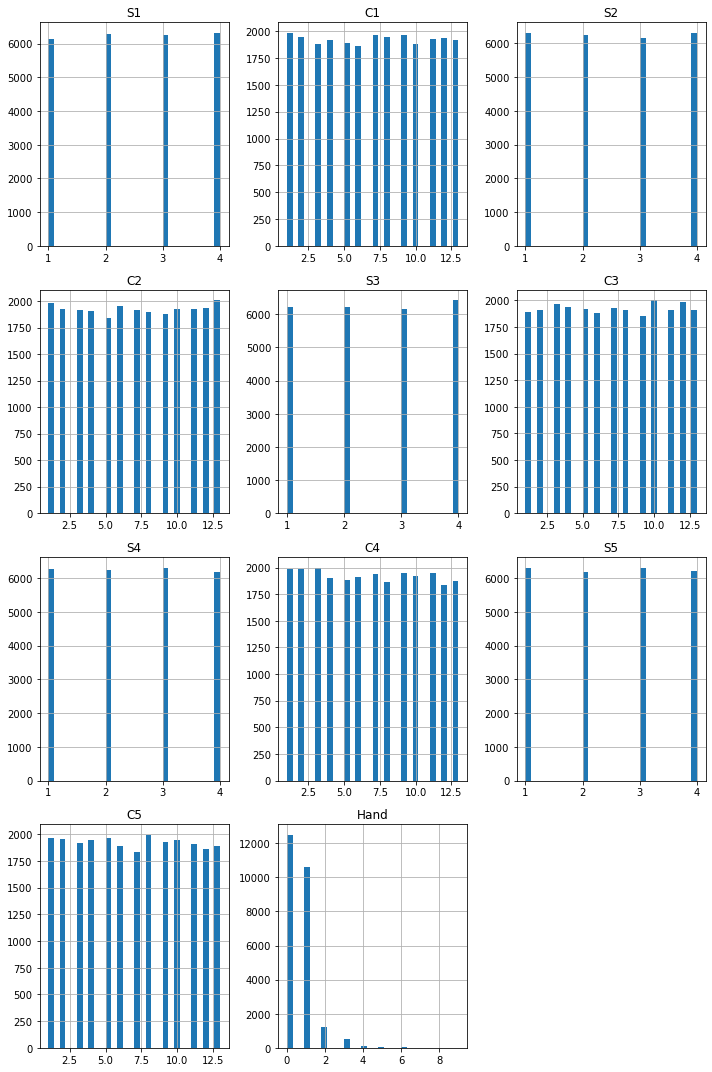

In [54]:
df.hist(bins=30, figsize=(10,15));
plt.tight_layout()
plt.show()

In [14]:
df.mode()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
0,4,1,1,13,4,10,3,3,3,8,0


0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        4
Name: Hand, dtype: int64


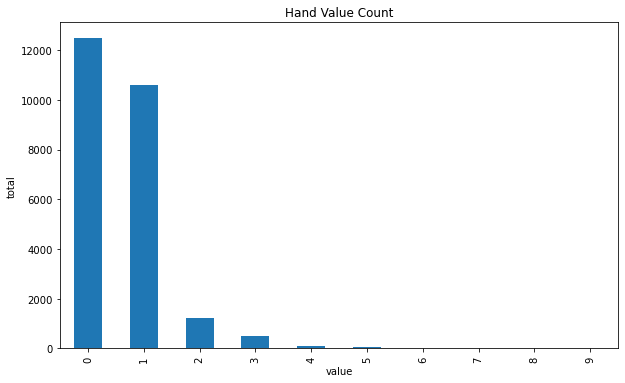

In [35]:
print(df["Hand"].value_counts())
df["Hand"].value_counts().plot(kind="bar", figsize=(10, 6));

plt.title("Hand Value Count")
plt.xlabel("value")
plt.ylabel("total");

The findings:
* We can see that the values are realtively even spread, with the means of the first 10 columns sitting around what we expect (2.5 for suit and 7 for number). 
* We have a count of 25009, and there are no missing values in that count
* A hand of 0 – nothing in hand – is by far the most common hand. Where if the model just predicted 0 every time, it'd get around a 50% accuracy score (12493/25009 empty hands).


In [36]:
df.corr()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Hand
S1,1.000000,-0.010277,-0.021337,0.008295,-0.019692,-0.009861,-0.017374,0.003897,-0.024241,0.006540,0.008838
C1,-0.010277,1.000000,0.004503,-0.011027,-0.000339,-0.026338,0.004104,-0.014483,0.004896,-0.016917,0.001976
S2,-0.021337,0.004503,1.000000,-0.002382,-0.029380,-0.005219,-0.021033,0.012099,-0.011914,0.005697,-0.000569
C2,0.008295,-0.011027,-0.002382,1.000000,-0.005294,-0.024771,-0.008333,-0.012991,0.000697,-0.016317,-0.005653
S3,-0.019692,-0.000339,-0.029380,-0.005294,1.000000,0.018030,-0.013071,0.001947,-0.030380,-0.002107,0.004533
C3,-0.009861,-0.026338,-0.005219,-0.024771,0.018030,1.000000,-0.003106,-0.016411,0.003817,-0.010842,-0.006951
S4,-0.017374,0.004104,-0.021033,-0.008333,-0.013071,-0.003106,1.000000,-0.008623,-0.018273,0.005260,-0.000984
C4,0.003897,-0.014483,0.012099,-0.012991,0.001947,-0.016411,-0.008623,1.000000,0.002883,-0.014596,0.009612
S5,-0.024241,0.004896,-0.011914,0.000697,-0.030380,0.003817,-0.018273,0.002883,1.000000,-0.003243,-0.005059
C5,0.006540,-0.016917,0.005697,-0.016317,-0.002107,-0.010842,0.005260,-0.014596,-0.003243,1.000000,-0.001741


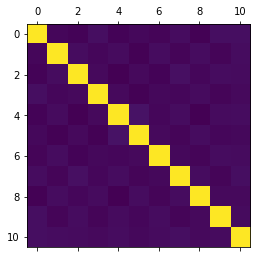

In [37]:
plt.matshow(df.corr())
plt.show()

As we'd expect, there isn't much of a correlation between the values, as we're dealing with a essentially random dataset.

## Modelling

In [4]:
# Prepare data
X = df.drop("Hand", axis=1)
y = df["Hand"]

# Split data into train and test sets
np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
np.random.seed(42)
model = RandomForestClassifier().fit(X_train, y_train)
model.score(X_test, y_test)

0.6019592163134746

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Linear-SVC": SVC(kernel="linear", C=0.025),
#           "SVC": SVC(gamma=2, C=1),
#           "Gaussian Process Classifier": GaussianProcessClassifier(1.0 * RBF(1.0), verbose=2),
#           "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=5, verbose=2),
         }

# Create a function that both fits and scores our models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and scores ML models.
    models: a dict of Sklearn models
    X_train: training data
    X_test: test data
    y_train: labels for training data
    y_test: labels for test data
    """
    
    np.random.seed(7)
    # Set up empty dict for our model scores
    model_scores = {}
    fitted_models = []
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        fitted_models.append(model)
        
    return [model_scores, fitted_models]

In [7]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test);


/Users/jacob/Documents/Post-Bootcamp/ml-projects/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
model_scores[0]

{'Logistic Regression': 0.49020391843262695,
 'KNN': 0.5515793682526989,
 'Random Forest': 0.6095561775289884,
 'Linear-SVC': 0.49020391843262695}

Out of the models tested, `RandomForest` seems to be the fastest.

### HyperParameter tuning using RandomizedSearchCV

In [5]:
# RandomForestClassifier hyperparameter grid 
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [12]:
np.random.seed(7)
rand_forest_rs = RandomizedSearchCV(RandomForestClassifier(),
                                    param_distributions=rf_grid,
                                    cv=, 
                                    n_iter=15,
                                    verbose=True)

rand_forest_rs.fit(X_train, y_train)
print("Our best parameters are:")
rand_forest_rs.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=15,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [22]:
print(f"After hyperparameter tuning our model got a score of {rand_forest_rs.score(X_test, y_test)}")
print(f"The model however scored higher with the default values.")

After hyperparameter tuning our model got a score of 0.604358256697321
The model however scored higher with the default values.
